# Let's implement The first paper that proposed the Transformer architecture that all of the new AI is using



**User**
where you built of the paper called "All you need is Attention"? </br>
**ChatGPT**
The paper titled "Attention Is All You Need" was published in 2017 by a team of researchers, including Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, and Illia Polosukhin. This landmark paper introduced the Transformer model, which is fundamentally based on the attention mechanism, eliminating the need for recurrent layers. This model has since become central to many advances in natural language processing and beyond, including the development of models like GPT (Generative Pre-trained Transformer).</br>

Check out the paper
https://arxiv.org/pdf/1706.03762.pdf







In [6]:
import requests

url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
r = requests.get(url)
with open('input.txt', 'wb') as f:
    f.write(r.content)


In [7]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [8]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


# Let's create a custom tokenizer 

In [9]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


ok... '65' is our vocabulary size

In [10]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


**Becasue we had a very samll vocabulary size the sequence of encoding is gonna be large this is the kinda of trade off we can expect when dealing with character genration models**

- Googgle uses **SentencePiece** https://github.com/google/sentencepiece , It  uses subword-units in there vocabulary 
- OpenAI uses **Tiktoken** https://github.com/openai/tiktoken?tab=readme-ov-file , it is a Byte pair encoding tokenizer</br>
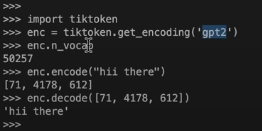</br>
Typically the indusrty standard is to use sub-word encodings, To keep our tokenizer simple we are going with character level encoding 

# tokenize input.txt file 

In [11]:
!pip install torch

In [12]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

# separate dataset into trainig set & Validation set

In [13]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

alright now that we have some validation data to work with to validate overfitting, Becasue we don't want to store the exact text file or to say we don't want our model return the same following texts as our dataset

# Chunk size 

In [14]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

 When we sample a chunk of data, It has multiple examples packed into it, lets say [18, 47, 56] the target value would be ===> 57; likewise  [18, 47, 56, 57, 58] ==> 1

**Let's illustrate the same with code**

In [15]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


so they're are 8 hidden examples in the 9 character chunk size

**Ok now that we are done with sequential data or the Time dimensions</br>
Lets now figure out how to deal with the batch dimensions**

Because has we feed multiple chunks everytime to our transformer model they are all stacked up into a single Tensor</br>

This is done for better GPU usage because they are every good at parallel processing i.e, process multiple chunks all at the same time


# Generalizing and introducing a Batch dimension

<img src="https://raw.githubusercontent.com/KarthikGowdaRamakrishna/DatasetDump/main/B*T*C.png" alt="Visual Representation of a 3D Logits Tensor">



In [16]:
tix = torch.randint(len(data) - block_size, len(data), (3,3))
print(tix)

tensor([[1115388, 1115391, 1115386],
        [1115389, 1115393, 1115388],
        [1115393, 1115388, 1115391]])


In [17]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

In [18]:
print(xb) # our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


Ok we have a batch of input to feed, that we can use for A Neural network

Let's go with the simplest Neural network in case of language modeling which is </br>
**The Bigram Language Model**

**step-1**


#### Initialization (`__init__`)
- **Embedding Layer**: In the `__init__` method of your model, you create an `nn.Embedding` layer with dimensions `(vocab_size, vocab_size)`. This is essentially setting up a lookup table where each row corresponds to a token in your vocabulary. The crucial aspect here is that each row (which represents a token) contains a vector of logits for each token in the vocabulary that might follow the key token.
- **Uninitialized Logits**: The vectors in this embedding table are initialized randomly and will be updated during the training process. The training aims to adjust these vectors so that they correctly predict the next token given the current token, by making the correct next token's logit higher relative to other logits.

#### Forward Pass (`forward`)
- **Input Tensor `idx`**: In the `forward` method, you receive `idx`, which is a batch of sequences of token indices. This tensor is of shape `(B, T)` where `B` is the batch size and `T` is the sequence length (e.g., 8 tokens per sequence in your example).
- **Logits Retrieval**: You pass this `idx` tensor to the `nn.Embedding` layer. The embedding layer uses each token index to fetch the corresponding logit vector. The output is a tensor of logits of shape `(B, T, vocab_size)`. Each `[b, t]` entry in this tensor contains a vector of logits, where each element of the vector is the raw score representing the likelihood of each vocabulary token being the next token after the token at position `t` in sequence `b`.


In [19]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B-batch,T-time(in our case it is chunkSize=8,C-channals or 64 or vocab size)

        return logits
    
m = BigramLanguageModel(vocab_size)
out = m(xb, yb)
print(out.shape)

torch.Size([4, 8, 65])


**Step-2**

#### Handling `targets` in `forward`
In the updated `forward` method, there is now a conditional structure to handle cases when `targets` are provided:

- **Logits**: As before, the `self.token_embedding_table(idx)` fetches a tensor of logits, shaped `(B, T, C)` where `B` is batch size, `T` is sequence length, and `C` is vocab size (same as before).

- **Loss Calculation**: If `targets` is provided (not `None`), the method calculates the cross-entropy loss between the predicted logits and the actual target tokens. This is essential for training the model, as it provides a measure of how well the model's predictions match the expected outcomes.

#### Processing Steps for Loss Calculation:
1. **Reshaping Logits and Targets**:
   - `logits.view(B*T, C)`: The logits tensor is reshaped from `[B, T, C]` to `[B*T, C]`. This flattening step is necessary because `F.cross_entropy` expects its inputs to be 2D (logits) and 1D (targets), where each row in the logits corresponds to a prediction, and the targets are the indices of the correct classes.
   - `targets.view(B*T)`: Similarly, the targets are reshaped from `[B, T]` to `[B*T]`, making them a flat list of indices corresponding to the true class labels for each input token.

Correct, there is no explicit need to apply the softmax function in your model's forward pass when using the `F.cross_entropy` function for calculating the loss. Here's why:

### Understanding `F.cross_entropy`
The `F.cross_entropy` loss function in PyTorch combines both the softmax activation and the cross-entropy loss calculation into a single step. This function is commonly used in training classification models, including those for language modeling. Here's how it operates:

1. **Logits to Probabilities**: `F.cross_entropy` takes raw logits as input and internally applies the softmax function to these logits. The softmax function converts the logits into probabilities by normalizing them, ensuring that the probabilities of all potential output classes sum to one.

2. **Loss Calculation**: Once the probabilities are obtained via the softmax, the function computes the cross-entropy loss. This loss measures the difference between the predicted probability distribution (from the softmax) and the target distribution, which is represented in a one-hot encoded fashion by the target indices.


In [20]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module): # BigramLanguageModel is defined as a subclass of nn.Module

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)#to convert it into a 2D for pyTrorch
            targets = targets.view(B*T) #this to 1D or '-1' if u want pytorch to assume targets
            loss = F.cross_entropy(logits, targets)

        return logits, loss

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)
    
    

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)


So we can guess what the expected loss would be has we known that there are **65 possible vocabulary** by using **negative log likelihood** that would be</br>
$$
-\ln\left(\frac{1}{65}\right) \approx 4.174
$$





**Step-3**
#### Method: `generate`


1. **Input Parameters**:
   - `idx`: This is the initial context provided as a tensor of token indices with shape `(B, T)`, where `B` is batch size (number of sequences to generate simultaneously), and `T` is the initial sequence length.
   - `max_new_tokens`: This specifies how many new tokens you want to generate for each sequence.

2. **Generation Loop**:
   - The method enters a loop that will iterate `max_new_tokens` times, adding one new token per iteration to each sequence.
   - **Logits Calculation**: For each iteration, the method first calls the model's forward method to get the logits for the current sequence (`idx`). These logits have the shape `(B, T, C)` where `C` is the vocabulary size.
   - **Focus on Last Time Step**: It then slices the logits to focus only on the last time step (`logits[:, -1, :]`), reducing the tensor to `(B, C)`. This slicing is crucial because you only need the logits for the last token in the current sequence to predict the next token.
##### Understanding `(logits[:, -1, :])`

This slice selects the logits for the last token in each sequence from the logits tensor that your model generates. Here's a breakdown of the indices and their meanings:

- **`:`**: This index selects all items along the batch dimension. If your batch size is `B`, it includes all batch items.
- **`-1`**: This index selects the last item along the sequence dimension. If each sequence in the batch contains `T` tokens, this index picks the logits corresponding to the last token in each sequence.
- **`:`**: This index selects all items along the last dimension, which is the vocabulary size `C`. This means you take all the logits that represent the scores for each vocabulary token being the next token.

##### Visual Representation

If we imagine the logits tensor `logits` with a shape `(B, T, C)`, you can think of it as a 3D block where:
- The length of the block is `B` (batch size).
- The depth of the block is `T` (sequence length).
- The height of the block is `C` (vocabulary size).

When you perform the slice `(logits[:, -1, :])`, you're effectively taking a vertical "slice" at the end of each sequence across all batches, which gives you the logits for the last token each sequence processed. Each "slice" you take out is a 2D matrix of shape `(B, C)`, where each row corresponds to the final token's logits for one sequence in the batch.

   - **Softmax Application**: A softmax function is applied to these logits to convert them into probabilities. The softmax is performed over the vocabulary dimension (`dim=-1`).
   - **Sampling**: The method then samples from these probabilities using `torch.multinomial`, which randomly picks indices based on the provided probabilities. This sampling step effectively chooses the next token for each sequence.<br>
   
 The `torch.multinomial` function doesn't necessarily choose the index with the highest probability, but rather it samples from the probability distribution provided to it. This means that while indices with higher probabilities are more likely to be selected, there is still a chance that indices with lower probabilities could be chosen. This introduces randomness and variety in the selection process, which is crucial for tasks like text generation where you might want to introduce variability and prevent the model from always outputting the most predictable text.

##### How Sampling Works with `torch.multinomial`

Here’s a bit more detailed explanation:

- **Probability Weighted Sampling**: The indices are sampled according to their probability weights in the `probs` tensor. For each row in `probs`, if you think of each element as a weight, `torch.multinomial` picks an index based on these weights. This is akin to putting weights on different sections of a roulette wheel, where sections with higher weights (probabilities) are larger but every section still has a chance to be selected.

- **Example**: If your probability distribution for a vocabulary of three words is `[0.1, 0.8, 0.1]`, while the index `1` (corresponding to the second word with a probability of 0.8) is indeed the most likely to be chosen, there's still a 10% chance for index `0` and a 10% chance for index `2` to be selected in each draw. This means:
  - If you sample many times, you'll see that index `1` is selected about 80% of the time, but not always.

- **`num_samples` Parameter**: This controls how many samples are drawn from each distribution row. If `num_samples=1`, one index is drawn per row of `probs`. If `num_samples` is greater than one, that many indices are drawn per row, with possible repetitions depending on the sampling.

   - **Sequence Update**: The newly sampled tokens (`idx_next`) are appended to the current sequence (`idx`), extending each sequence by one token.

3. **Return Updated Sequences**:
   - After completing the loop, the updated sequences containing both the original and newly generated tokens are returned. These sequences now have a length of `T + max_new_tokens`.


In [21]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module): # BigramLanguageModel is defined as a subclass of nn.Module

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)#to convert it into a 2D for pyTrorch
            targets = targets.view(B*T) #this to 1D or '-1' if u want pytorch to assume targets
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)
#intialzing 'idx' with zeros is not a bad idea has in our vocab it's basically a new line character 
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


**At this point it looks rubbish because we are using only the previous character has the history later on when we use whole as the previous sequence of the history this model will be more efficent**

Ok let's train the model with that in mind....</br>
to do that let's start with optimizing 

## optimization 

In [22]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

Typically the learning rate is roughly around ` '3e-4' `but for very very small networks like in our case we can get away with ` '1e-3' `

Now let's take gradients and update the parameters from the ` optimizer ` object



##### Loss Calculation and Backpropagation
```python
logits, loss = m(xb, yb)
optimizer.zero_grad(set_to_none=True)
loss.backward()
optimizer.step()
```
- **Forward Pass**: The model `m` processes the input batch `xb` and outputs `logits` and `loss`. The loss is calculated based on how well the model's logits match the targets `yb`.
- **Zeroing Gradients**: `optimizer.zero_grad(set_to_none=True)` clears old gradients from the last step before the new gradients are calculated. This is necessary because gradients accumulate by default, overwriting them with `None` might provide a small performance benefit.
- **Backpropagation**: `loss.backward()` computes the gradient of the loss with respect to the model parameters (`m.parameters()`). These gradients are used by the optimizer to update the model weights.
- **Parameter Update**: `optimizer.step()` updates the model parameters using the gradients computed by `loss.backward()` according to the AdamW optimization algorithm.



In [23]:
batch_size = 32
for steps in range(10000): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())


2.5727508068084717


ok.. with our indie optimizition let's check out how our model is doing now

In [24]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))



Iyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henoure wounonthioneir thondy, y heltieiengerofo'dsssit ey
KIN d pe wither vouprrouthercc.
hathe; d!
My hind tt hinig t ouchos tes; st yo hind wotte grotonear 'so it t jod weancotha:
h hay.JUCle n prids, r loncave w hollular s O:
HIs; ht anjx?

DUThinqunt.

LaZAnde.
athave l.
KEONH:
ARThanco be y,-hedarwnoddy scace, tridesar, wnl'shenous s ls, theresseys
PlorseelapinghiybHen yof GLUCEN t l-t E:
I hisgothers je are!-e!
QLYotouciullle'z


**Let's goooo!!! JK it's no where close to GPT-2, Sure it's getting some ` My `, ` The `, ` Five ` right here and there but never the less it is improvement we take those**

**Any ways why is this the case?.... Because the tokens are not talking to each other so the previous context of whatever was generated where only looking at the last character to make the predictions what comes next, This is where the ` "Attetion Is All You Need" ` paper comes in clutch**

# Understanding the math behind  self-attention


##### Setting the Seed
```python
torch.manual_seed(42)
```
- This line sets the seed for random number generation to ensure reproducibility. It ensures that the random numbers generated by PyTorch are the same every time the code runs.

##### Matrix `a` (Weight Matrix)
```python
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
```
- `torch.tril(torch.ones(3, 3))` creates a 3x3 matrix with ones on and below the main diagonal (lower triangular matrix).
- Dividing each row of `a` by the sum of its elements normalizes the rows so that they sum to one. This makes `a` a stochastic matrix where each row can be interpreted as a set of weights that sum to one.

##### Matrix `b` (Value Matrix)
```python
b = torch.randint(0, 10, (3, 2)).float()
```
- This creates a 3x2 matrix of random integers between 0 and 9, then converts it to floats. These represent the values that will be aggregated.

##### Matrix Multiplication (Weighted Aggregation)
```python
c = a @ b
```
- The `@` operator performs matrix multiplication. Since `a` is a normalized weight matrix, the operation `a @ b` performs a weighted aggregation of `b`’s columns.
- Each row in `c` is a weighted combination of the values in `b`, with the weights provided by the corresponding row in `a`.


In [30]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(12)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[3., 3.],
        [2., 7.],
        [3., 6.]])
--
c=
tensor([[3.0000, 3.0000],
        [2.5000, 5.0000],
        [2.6667, 5.3333]])



##### Understanding the Self-Attention Mechanism

Self-attention is a mechanism that allows a model to weigh the importance of different parts of the input data differently. In the context of sequence tasks, like language processing, it helps the model to focus on different positions of the input sequence when predicting each output token.

##### Components of Self-Attention

In the context of Transformers and self-attention, you typically deal with three matrices:
1. **Queries (`Q`)**: A set of vectors that correspond to each position in the sequence, asking "what to focus on?"
2. **Keys (`K`)**: Another set of vectors that are matched against the queries, essentially the parts of the sequence that are being focused on.
3. **Values (`V`)**: The vectors that contain the actual content that we want to aggregate based on the focus.

##### The Process of Self-Attention

1. **Attention Scores**: First, a set of attention scores is computed by performing a dot product between the queries and the keys. This is analogous to your matrix `a` after it's been normalized. In self-attention, the result of `Q @ K.T` (the queries times the transpose of the keys) indicates how much focus each query should place on each key.
2. **Normalization**: These scores are then normalized (typically using softmax) to ensure they sum to one, forming a probability distribution. This is equivalent to the normalization step in your toy example.
3. **Weighted Aggregation**: Finally, the normalized attention scores are used to create a weighted sum of the value vectors. This weighted sum is the output of the self-attention mechanism for each position in the sequence, analogous to how matrix `c` is computed by `a @ b` in your example.

##### Key Takeaways Relating to Self-Attention

- **Matrix `a`**: Represents the attention scores that have been normalized across each row. In self-attention, this would correspond to the attention weights after applying softmax to the raw attention scores.
- **Matrix `b`**: Represents different feature vectors (values in the self-attention mechanism) for each position in the sequence that we want to aggregate.
- **Matrix `c`**: Represents the final output of the self-attention for each position in the sequence, which is the weighted sum of the value vectors, where the weights are the attention scores.

##### Why It's Helpful

The toy example abstractly demonstrates the core mathematical operation behind self-attention: weighting information (values) according to its relevance (attention scores) to a given query. By understanding this simpler case, you can better grasp the operations involved in the more complex self-attention mechanism where each step is essentially a high-dimensional, learned version of weighted aggregation. The self-attention mechanism generalizes this by learning the weights dynamically for each query-key pair, allowing the model to decide which parts of the input sequence are important for each output element.

**Ok let's break it down into simpler terms with a simpler example**

In [31]:
# consider the following toy example:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

So let's consider ` 1st batch off the 4 batches ` and ` 5th token in the 8 length seuqence or 'T' `, you don't want this token to talk to say 6th, 7th or 8th token right? you only want it talk to look at the what was generated previous that is `1st, 2nd, 3rd, 4th token ` </br>
**How do we do that? The simplest way is to take the average of all the preceding elements i.e, `1st, 2nd, 3rd, 4th token ` that would become a sort of faeture Vector that summarizes the current generated token in context of it's history**

##### Of course this is a very weak form of interaction the communication is very bad we have lost tons of information about the spatial arrangements of all the preceeding tokens, We'll work with this for now and bring that information back later on </br>
Let's implement that

In [32]:
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C) slicing the sequence at the curren i.e, t+1 returning a 2D
        xbow[b,t] = torch.mean(xprev, 0)


In [33]:
x[0] # without taking the averages

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [34]:
xbow[0]# taking the averages

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

Getting back to our previous example and breaking it down....

In [35]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3)) # this is how we wish the communication goes or needs to be structured right!
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[ 2.,  7.],
        [ 8., 11.],
        [14., 16.]])


Because the the 1st row of 'a' is only 1 followed up with 0's </br>
The o/p 'c' is just the dot product of the first element and </br>the 'b''s first column 

**So like wise if you can see the pattern in 'c' the dot products('a'X'b') are getting summed up as you go down the rows in 'c'**

#### so with that in mind we can kinda see how we can get the averages of rows 'b' in a incremental fashion ..... How you ask!!? </br>
***By Normalizing the 'a' rows so that they sum to 1 and taking the dot product of this will give the respective averages of the rows or in a bigger scheme things the averages of the preceding tokens***</br>

Let's see how that looks.....

In [36]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(12)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[3., 3.],
        [2., 7.],
        [3., 6.]])
--
c=
tensor([[3.0000, 3.0000],
        [2.5000, 5.0000],
        [2.6667, 5.3333]])


##### Let's just check if this implementation is returning the same value has the 'xbow' from before for which we used double for loop to get the same average values

In [37]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)

In [38]:
wei #This our 'a'

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [39]:
x #This our 'b'

tensor([[[ 0.1808, -0.0700],
         [-0.3596, -0.9152],
         [ 0.6258,  0.0255],
         [ 0.9545,  0.0643],
         [ 0.3612,  1.1679],
         [-1.3499, -0.5102],
         [ 0.2360, -0.2398],
         [-0.9211,  1.5433]],

        [[ 1.3488, -0.1396],
         [ 0.2858,  0.9651],
         [-2.0371,  0.4931],
         [ 1.4870,  0.5910],
         [ 0.1260, -1.5627],
         [-1.1601, -0.3348],
         [ 0.4478, -0.8016],
         [ 1.5236,  2.5086]],

        [[-0.6631, -0.2513],
         [ 1.0101,  0.1215],
         [ 0.1584,  1.1340],
         [-1.1539, -0.2984],
         [-0.5075, -0.9239],
         [ 0.5467, -1.4948],
         [-1.2057,  0.5718],
         [-0.5974, -0.6937]],

        [[ 1.6455, -0.8030],
         [ 1.3514, -0.2759],
         [-1.5108,  2.1048],
         [ 2.7630, -1.7465],
         [ 1.4516, -1.5103],
         [ 0.8212, -0.2115],
         [ 0.7789,  1.5333],
         [ 1.6097, -0.4032]]])

In [40]:
xbow2 #This is 'c'

tensor([[[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]],

        [[ 1.3488, -0.1396],
         [ 0.8173,  0.4127],
         [-0.1342,  0.4395],
         [ 0.2711,  0.4774],
         [ 0.2421,  0.0694],
         [ 0.0084,  0.0020],
         [ 0.0712, -0.1128],
         [ 0.2527,  0.2149]],

        [[-0.6631, -0.2513],
         [ 0.1735, -0.0649],
         [ 0.1685,  0.3348],
         [-0.1621,  0.1765],
         [-0.2312, -0.0436],
         [-0.1015, -0.2855],
         [-0.2593, -0.1630],
         [-0.3015, -0.2293]],

        [[ 1.6455, -0.8030],
         [ 1.4985, -0.5395],
         [ 0.4954,  0.3420],
         [ 1.0623, -0.1802],
         [ 1.1401, -0.4462],
         [ 1.0870, -0.4071],
         [ 1.0430, -0.1299],
         [ 1.1138, -0.1641]]])

As we can see this are two give identical results 

In [41]:
xbow[0],xbow2[0]

(tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]),
 tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]))


### Version 3: Using Softmax

In this approach:

- **Softmax**: The use of softmax introduces a non-linear transformation that focuses more on larger values. Softmax emphasizes elements with higher initial weights (before applying `-inf`), making the distribution of weights more "peaky" around more significant values. This can be particularly useful when you want to focus more on recent steps rather than treating all past steps equally.
- **Masking with `-inf`**: This effectively forces the softmax to ignore certain parts (upper triangular in this case), ensuring that only the valid (previous and current) steps are considered. This adds flexibility in scenarios where temporal dynamics are important, such as in sequence modeling and time series analysis where more recent observations might be more relevant.

### When to Choose Softmax Over Normalization

1. **Focus on Recent Data**: Softmax is preferable when there's a need to emphasize more recent data points over older ones. The exponential nature of softmax can be tuned to decrease the influence of older entries more sharply than simple normalization.
   
2. **Handling of Outliers and Extreme Values**: Softmax can handle outliers better because it exponentially scales down smaller values compared to larger ones, thereby reducing their relative influence automatically.

3. **Need for Soft Decisions**: Softmax is useful in scenarios where soft decisions about the importance of features are beneficial, as it can highlight the most relevant features more distinctly than a simple average.

4. **Backpropagation and Learning**: If weights need to be learned or adjusted through gradients (as often used in trainable attention mechanisms), softmax provides a differentiable operation that interacts well with backpropagation, especially when combined with other non-linear transformations in neural networks.


In [42]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei 

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [43]:
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [44]:
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow2, xbow3)

True

## self-attention!

All the previous steps are doing is just taking average like i said before that's not good enough, 
We don't want that, Because diffrent tokens find diffrent tokens more or less interseting, right now all our weights are pretty uniform in nature</br>
***We want that to be data dependent, to do so we need to gather information from the past*** **This exactly the problem self-attention solves**

## The way it does that is giving every single token/node at each position  two vectors ***Query and Key*** 

**Query - what am i lookin for?; Key - what do i contain.**

#### To get the affinites between this tokens in the sequece we take the DOT product b/w the Keys & the queries ******This product will become the new weight***** so if the key & query align very will get a very high amount of affinity 

Let's Implement this, with **A Single self-attention head**

##### Self-Attention Components

1. **Define the Input**:
   ```python
   torch.manual_seed(1337)
   B, T, C = 4, 8, 32  # batch, time, channels
   x = torch.randn(B, T, C)
   ```
   Here, `x` is the input tensor with dimensions for batch size (B), sequence length (T), and number of channels/features (C). This could represent, for example, a batch of sequences where each element of the sequence has 32 features.

2. **Set Up Attention Mechanism**:
   ```python
   head_size = 16
   key = nn.Linear(C, head_size, bias=False)
   query = nn.Linear(C, head_size, bias=False)
   ```
   - **Head Size**: Each head in an attention mechanism can be thought of as a distinct way of projecting the input sequences into a space where attention weights are computed. Here, `head_size` is 16, meaning each key and query vector will have 16 elements.
   - **Key and Query Projections**: You set up linear transformations for projecting the input into "key" and "query" spaces using the original feature size `C` and the desired `head_size`. These projections help determine how each element of the sequence attends to every other element.

3. **Calculate Keys and Queries**:
   ```python
   k = key(x)   # (B, T, 16)
   q = query(x) # (B, T, 16)
   ```
   - `k` and `q` are the projected "key" and "query" matrices. Each row in `k` and `q` corresponds to a time step in the input sequence, with each time step now represented as a 16-dimensional vector.

4. **Compute Attention Weights**:
   ```python
   wei = q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)
   ```
   - **Matrix Multiplication**: You perform a dot product between each query and all keys, which is done by matrix multiplying `q` with the transpose of `k`. The resulting `wei` matrix (`B, T, T`) contains raw attention scores for each time step attending to every other time step within the same batch.
   - The shape transformation is as follows:
     - `q` has a shape of `[B, T, 16]`.
     - `k.transpose(-2, -1)` changes `k` from `[B, T, 16]` to `[B, 16, T]`.
     - The resulting `wei` after the matrix multiplication has a shape of `[B, T, T]`, where each element `[b, i, j]` represents the attention score from time step `i` to `j` in batch `b`.

##### Sample Dimension Transformations

To visualize how dimensions transform, consider a sample matrix for a single batch (`B=1` for simplicity):
- Let `x` be `[1, 8, 32]` (single batch, 8 time steps, 32 features each).
- After passing through `key` and `query` linear layers, both `k` and `q` become `[1, 8, 16]`.
- Transposing `k` gives `[1, 16, 8]`.
- Multiplying `q @ k.transpose(-2, -1)` results in `[1, 8, 8]`, where each `8x8` matrix row corresponds to a query attending to all keys, providing the raw attention scores.

##### Use in the Attention Mechanism

The raw attention scores in `wei` are then processed (usually masked and softmax-applied) to generate probabilities that are used to weigh the inputs differently based on the computed attention, guiding the model to focus more on relevant parts of the input data for each output prediction. This is crucial for tasks where the relationship between different parts of the input directly affects the output, such as in sequence modeling and natural language processing.

In [45]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)

k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

out = wei @ x

out.shape

torch.Size([4, 8, 32])

In [46]:
wei

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
         [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
         [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
         [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1687, 0.8313, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2477, 0.0514, 0.7008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4410, 0.0957, 0.3747, 0.0887, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0069, 0.0456, 0.0300, 0.7748, 0.1427, 0.0000, 0.0000, 0.0000],
         [0.0660, 0.089

Previously weight was applied in the same way to all the batch element, **Now every single batch has diffrent weights**


#####  Generate Values and Output
```python
v = value(x)  # (B, T, 16)
out = wei @ v  # (B, T, T) @ (B, T, 16) ---> (B, T, 16)
```
- `value(x)` transforms `x` into `v`, which also has shape `[B, T, head_size]`.
- The final matrix multiplication `wei @ v` computes the weighted sum of values based on the attention weights. This results in `out`, with shape `[B, T, head_size]`, where each element in the sequence is now a weighted combination of all values in the sequence, weighted according to the computed attention scores.



In [47]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

In [48]:
wei

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
         [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
         [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
         [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1687, 0.8313, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2477, 0.0514, 0.7008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4410, 0.0957, 0.3747, 0.0887, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0069, 0.0456, 0.0300, 0.7748, 0.1427, 0.0000, 0.0000, 0.0000],
         [0.0660, 0.089

### some impoertant notes in Understanding Attention and its Variants

1. **Attention as a Communication Mechanism**:
   - Attention allows different parts of data (e.g., different positions in a sequence) to interact with each other in a flexible way. It can be thought of as nodes in a graph communicating with each other, where the edges (connections) are dynamically established based on the data itself.

2. **Positional Encoding**:
   - Since attention mechanisms do not inherently process data in any specific order (i.e., they lack the notion of "space" or sequence), positional encodings are necessary to provide context about the position of tokens in a sequence. This is crucial for tasks where the order of inputs matters, such as time-series analysis or language processing.

3. **Independence Across Batches**:
   - Each example in a batch is processed independently. This means that the attention mechanism computes weights and aggregates information separately for each sequence in the batch.

4. **Encoder vs. Decoder Blocks**:
   - The use of masking (with `tril`) distinguishes a decoder block, which uses the mask to prevent information flow from future tokens (autoregressive property), from an encoder block where all tokens can attend to all others freely because there is no such masking. Removing the masking line would convert the block into an "encoder" style block.

5. **Self-Attention vs. Cross-Attention**:
   - Self-attention means both keys, queries, and values come from the same source (like in this example). In cross-attention, typically used in encoder-decoder architectures like in Transformer models, the queries come from one source (e.g., decoder), and the keys and values come from another (e.g., encoder).

6. **Scaled Attention**:
   - The scaling factor (`head_size**-0.5` or \(1/\sqrt{\text{head\_size}}\)) is used to adjust the variance of the dot products in the attention mechanism, ensuring that the softmax function applied subsequently does not become too sharp (saturate) and retains a meaningful gradient. This scaling helps maintain a balance where the softmax output remains sensitive to variations in the input weights.

### Code Demonstration

The code shows how scaling affects the variance of the computed weights (`wei`) before applying softmax:


In [49]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [50]:
k.var()

tensor(1.0449)

In [51]:
q.var()

tensor(1.0700)

In [52]:
wei.var()

tensor(1.0918)


- **Variance Check**: It calculates and prints the variance of `k`, `q`, and `wei`. The variances of `k` and `q` are close to 1 because they are sampled from a normal distribution. After applying the scaling factor, `wei` also has a variance close to 1, illustrating that the scaling effectively normalizes the attention scores.


In [53]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [54]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

- **Softmax Application**: The softmax application to an example vector shows how the scores are transformed into a probability distribution. The output tensor shows the probabilities assigned to each element, which sum to 1.


### Layer Normalization vs. Batch Normalization

- **Batch Normalization**: Normalizes the data across the batch dimension for each feature independently. It is beneficial for convolutional networks where feature standardization across different batches is crucial.
- **Layer Normalization**: Normalizes the data across the features within a single sample. This is particularly useful in scenarios where the batch size is small or where the internal state needs to be normalized independently for each timestep or sample, such as in RNNs.


In [55]:
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

1. **Initialization (`__init__` Method)**:
   - **`dim`**: This parameter specifies the dimension of the features for which gamma (scale) and beta (shift) parameters are to be learned.
   - **`eps` (epsilon)**: A small value added to the variance to prevent division by zero.
   - **`gamma`**: Initialized as a vector of ones. This is a learnable parameter used to scale the normalized data.
   - **`beta`**: Initialized as a vector of zeros. This is a learnable parameter used to shift the normalized data.

2. **Forward Pass (`__call__` Method)**:
   - **Mean and Variance Calculation**:
     - `xmean = x.mean(1, keepdim=True)`: Computes the mean across the feature dimension (`dim=1`) for each sample in the batch, keeping the dimension for broadcasting.
     - `xvar = x.var(1, keepdim=True)`: Computes the variance in the same way.
   - **Normalization**:
     - `xhat = (x - xmean) / torch.sqrt(xvar + self.eps)`: Normalizes each feature by subtracting the mean and dividing by the square root of the variance adjusted by `eps`.
   - **Apply Gamma and Beta**:
     - `self.out = self.gamma * xhat + self.beta`: Scales and shifts the normalized data using the parameters `gamma` and `beta`.

3. **Parameters Method**:
   - Returns the list of parameters `[self.gamma, self.beta]` that should be learned during training.



# Let's implement some more concepts from the "Attention Is All Need" paper and piece together all the components that we have worked on in this notebook  and add the code .py file for scalability purposes

<img src="https://raw.githubusercontent.com/KarthikGowdaRamakrishna/DatasetDump/main/ArcDiagram.png" alt="Visual Representation of a 3D Logits Tensor">

### Single Self-Attention Block Implementation

In this code, a single self-attention block is implemented within the `Head` class:

```python
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
```

Each head computes the keys, queries, and values by transforming the input `x` through three separate linear layers without biases, paralleling the scaled dot-product attention mechanism described in the paper:

```python
k = self.key(x)   # (B,T,C)
q = self.query(x) # (B,T,C)
```

These transformed values are then used to compute the attention scores:

```python
wei = q @ k.transpose(-2,-1) * C**-0.5
wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
```

This sequence shows dot products scaled by the inverse square root of the dimension (implementing the "Scaled Dot-Product Attention"), followed by masking and softmax application. This ensures that each position can only attend to previous positions, a necessary feature for autoregressive models.

### Multi-Headed Self-Attention Block

**Conceptual Overview:**
In the Transformer model, the Multi-Headed Self-Attention mechanism is designed to run several attention mechanisms (heads) in parallel. The core idea is that each head captures different aspects of the data by projecting the inputs (queries, keys, and values) into different subspaces. By doing this, the model can attend to different positions and integrate information from different representation subspaces simultaneously.

**Code Implementation:**
Here’s how the Multi-Headed Self-Attention is implemented in our code:

```python
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out
```

- **Heads Instantiation:** Multiple instances of the `Head` class are created and stored in a `ModuleList`. Each `Head` instance performs self-attention and operates on a different projected subspace of the input data.
- **Concatenation and Projection:** The outputs of all heads are concatenated along the feature dimension, effectively combining the different attention perspectives into one tensor. This concatenated output is then projected back to the original dimensionality with a linear transformation (`self.proj`). This ensures that the multi-head attention output can be seamlessly integrated into the subsequent parts of the network.

**Relation to the Transformer Paper:**
As shown in the paper, this setup allows the model to "jointly attend to information from different representation subspaces at different positions," which is crucial for the model's ability to understand complex dependencies in the data.

### Feedforward Layer of the Transformer Block

**Conceptual Overview:**
The feedforward layer in each Transformer block is applied to each position separately and identically. This part of the network is designed to transform the representation from the self-attention layer further and can be adjusted independently for each position in the sequence, adding another level of transformation capability to the model.

**Code Implementation:**
```python
class FeedFoward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
```

- **Sequential Model:** The feedforward network is implemented as a sequence of layers — first, a linear layer expands the dimensionality from `n_embd` to `4 * n_embd`, followed by a ReLU activation for non-linearity, and another linear layer that projects the representation back to the original dimensionality. Dropout is applied for regularization.
  
**Relation to the Transformer Paper:**
This setup is directly aligned with the description in the paper, where each position’s output from the self-attention layer is processed through two linear transformations with a ReLU activation in between. The use of different parameters at different positions enables specific adaptations of the transformer block outputs before they are fed into the next layer.

### Residual Connections

**Conceptual Overview:**
Residual connections are a critical feature in deep neural networks, particularly in models like the Transformer where depth (number of layers) is substantial. They help in mitigating the vanishing gradient problem by allowing an alternate shortcut path for the gradient during backpropagation.

**Code Implementation:**
In each Transformer block, after the self-attention and the feedforward network, we have:
```python
x = x + self.sa(self.ln1(x))
x = x + self.ffwd(self.ln2(x))
```

- **Addition Operation:** The output from the self-attention layer and the feedforward layer is added to the input of each layer (`x`). This is the essence of the residual connection — the input to each sub-layer is added to its output.

**Relation to the Transformer Paper:**
The implementation mirrors the Transformer model from the paper, where the output of each sub-layer is the input added to the function applied to the input: `LayerNorm(x + Sublayer(x))`. The use of LayerNorm following the residual addition helps in stabilizing the learning process by normalizing the layer outputs.


In [56]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.209729 M parameters
step 0: train loss 4.4116, val loss 4.4022
step 100: train loss 2.6568, val loss 2.6670
step 200: train loss 2.5089, val loss 2.5057
step 300: train loss 2.4195, val loss 2.4336
step 400: train loss 2.3502, val loss 2.3565
step 500: train loss 2.2961, val loss 2.3123
step 600: train loss 2.2405, val loss 2.2493
step 700: train loss 2.2051, val loss 2.2186
step 800: train loss 2.1634, val loss 2.1864
step 900: train loss 2.1239, val loss 2.1502
step 1000: train loss 2.1029, val loss 2.1301
step 1100: train loss 2.0689, val loss 2.1171
step 1200: train loss 2.0384, val loss 2.0796
step 1300: train loss 2.0255, val loss 2.0645
step 1400: train loss 1.9915, val loss 2.0366
step 1500: train loss 1.9705, val loss 2.0318
step 1600: train loss 1.9635, val loss 2.0474
step 1700: train loss 1.9394, val loss 2.0122
step 1800: train loss 1.9092, val loss 1.9969
step 1900: train loss 1.9071, val loss 1.9864
step 2000: train loss 1.8850, val loss 1.9964
step 2100: train loss 1.

## This code can be put into out .py file and excuted i.e, ` python filename.py ` in any python environment and get the same output for scalability 


### Decoder-Only Transformer

The entire architecture we've implemented functions as a Transformer decoder, without an accompanying encoder

<img src="https://raw.githubusercontent.com/KarthikGowdaRamakrishna/DatasetDump/main/Noencode.png">

This decoder-only setup is indicated by the use of causal masking within the self-attention blocks to prevent future tokens from influencing the prediction of current tokens, which is a hallmark of decoders in sequence generation tasks.

### Scaling Up with Encoding and Cross-Attention

To scale up your model (e.g., for handling longer sequences or additional complexity), incorporating an encoder and cross-attention modules would be beneficial. Cross-attention would allow the decoder to attend over all positions in an encoded input sequence, enhancing the model's ability to integrate contextual information across the entire input, a critical feature for tasks like machine translation or complex question-answering.

Let's break down how these components work together using your French to English translation example.

```
# French to English translation example:

# <--------- ENCODE ------------------><--------------- DECODE ----------------->
# les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>

```

### Encoder

**Purpose**: The encoder processes the input sequence ("les réseaux de neurones sont géniaux!") and converts it into a series of continuous representations, which capture both the semantic and syntactic essence of the input text. These representations are rich in context and serve as the foundation for generating the translated output.

**How it works**: In a Transformer model, the encoder consists of a stack of identical layers, each containing two sub-layers:
1. A self-attention mechanism that helps the encoder look at other words in the input sentence as it encodes a specific word.
2. A position-wise fully connected feed-forward network which transforms the self-attended features independently at each position.

Each of these layers has residual connections around it and is followed by layer normalization.

### Decoder

**Purpose**: The decoder generates the output sequence one token at a time. It processes the special start token "<START>" and then generates each subsequent word until it produces the end token "<END>", forming the translation "neural networks are awesome!<END>".

**How it works**: The decoder also consists of a stack of identical layers, but each layer has three sub-layers:
1. A self-attention mechanism, which, unlike in the encoder, is masked to prevent positions from attending to subsequent positions. This ensures that the predictions for position \(i\) can depend only on the known outputs at positions less than \(i\).
2. A cross-attention layer, where the decoder attends over the encoder’s output. This is crucial as it allows each position in the decoder to attend to all positions in the input sequence, effectively using the encoder's context to decide the best output.
3. A position-wise fully connected feed-forward network.

Like in the encoder, each of these layers has residual connections and layer normalization.

### Cross-Attention

**Purpose**: Cross-attention is the mechanism through which the decoder can access the entire input sentence in one go. It lets the decoder focus on relevant parts of the input sequence during each step of the output generation.

**How it works in the context of your example**:
- As the decoder begins generating the translation, starting with "<START>", it uses cross-attention to weigh parts of the input sentence that are relevant to generating the next word. For instance, when deciding on the translation for "les réseaux", the decoder might focus more on the words related to "neural networks" through the attention mechanism.
- At each step, the decoder looks back at the entire input sequence (via the encoder’s output) to gather the necessary context before deciding on the next word.

### Scaling Up with Encoding and Cross-Attention

Scaling up a Transformer model to handle more complex, longer, or more nuanced translations involves optimizing these encoder and decoder architectures. Enhancements could include:
- **Increasing the number of layers** in both the encoder and decoder to capture more complex dependencies.
- **Expanding the number of attention heads** to allow the model to focus on multiple different parts of the input sequence simultaneously.
- **Integrating more sophisticated positional encodings** or adjustments to the self-attention mechanism to better handle long-distance dependencies or nuanced grammatical structures.



### Fine-Tuning for Real-World Implications

Fine-tuning the model involves adjusting the pretrained model to specific tasks by continuing training on a task-specific dataset. This approach is vital for tailoring the model's responses to particular domains or languages, significantly improving its effectiveness in real-world applications.

By connecting these elements directly to your code and the foundational Transformer paper, we can see how our implementation faithfully reproduces key aspects of the

 Transformer architecture, providing a solid basis for building advanced language processing systems.
    
 - For practical applications like real-time translation or handling domain-specific jargon, the model might be further fine-tuned with additional training on specialized corpora or adapted using techniques like transfer learning to improve accuracy and relevance to specific contexts.